In [1]:
#include("MAB_module.jl")
include("environment.jl")
include("algorithm_base.jl")
include("eps_greedy.jl")
include("rs.jl")
include("lsx.jl")
#include("meta-bandit.jl")
include("tompson_sampling.jl")
include("ucb1tuned.jl")

update! (generic function with 5 methods)

In [2]:
using Plots
using Statistics
#using Base.Threads

┌ Info: Recompiling stale cache file /home/kamilab-deep2/.julia/compiled/v1.0/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184


In [3]:
mutable struct MYRS <: Algorithm
    env::Environment
    actionValues::Vector{Float64}
    w::Vector{Float64}             #numbers of  rewards.
    l::Vector{Float64}
    average::Vector
    r::Float64
    gamma::Float64
    alpha_r::Float64
    opt::Bool
    test_name::String
    #constructor
    function MYRS(;env::Environment, r::Float64, gamma::Float64, alpha_r::Float64, opt=false, test_name="")
        return new( env,
                    zeros(env.arm_num),
                    zeros(env.arm_num),
                    zeros(env.arm_num),
                    zeros(env.arm_num),
                    r,
                    gamma,
                    alpha_r,
                    opt,
                    test_name)
    end
end

In [4]:
function init!(algo::MYRS)
    algo.actionValues = zeros(algo.env.arm_num)
    
    for i=1:algo.env.arm_num
        algo.w[i] = eps(0.0)
        algo.l[i] = eps(0.0)
    end
    
    if algo.opt
        sorted_pro = sort(algo.env.arm_pros, rev=true)
        algo.r = (sorted_pro[1] + sorted_pro[2]) / 2
    else
        algo.r = 1.
    end
end

function select_arm(algo::MYRS)
    #return index of maximum value in the action values.
    return greedy(algo)
end

function calc_value(algo::MYRS, selected, reward)
    
    algo.average[selected] = algo.w[selected]  / (algo.w[selected] + algo.l[selected])
    
    if !algo.opt
        algo.r += algo.alpha_r * (algo.average[selected] - algo.r)
        #algo.r += algo.alpha_r * (reward - algo.r)
    end

    
    if algo.test_name == "gamma"
        for i=1:algo.env.arm_num
                algo.w[i] = algo.gamma * algo.w[i]
                algo.l[i] = algo.gamma * algo.l[i]
            
                algo.actionValues[i] = (algo.w[i]+algo.l[i])*(algo.average[i] - algo.r)
        end
    else
        algo.actionValues[selected] = (algo.w[selected]+algo.l[selected])*(algo.average[selected] - algo.r)
    end

    #update this experiment's current state.
    if reward == 1
        algo.w[selected] += 1
    else
        algo.l[selected] += 1
    end
    

    #@show algo.r selected
end

#update each variables and calc parameters for epsilon greedy algorithm
function update!(algo::MYRS)
    selected = select_arm(algo)
    reward = get_reward(algo.env.arm_pros, selected)

    #calculation of action value and save.
    calc_value(algo, selected, reward)

    #calc regret.
    regret = algo.env.max_pro - algo.env.arm_pros[selected]

    return selected, regret, reward

end

update! (generic function with 6 methods)

In [5]:
function simulation(;sim_num::Int, steps::Int, update_per::Int, arm_num=4, dynamic=false)
    #argument checking.
    if dynamic && update_per <= steps && steps % update_per != 0
        println("update number error.")
        return
    end

    update_num = div(steps, update_per)#convert(Int64, steps/update_per)
    env = Environment(arm_num)

    algo_dict = Dict()
    
    for gamma=[0.999]
        #gamma = 0.999
        alpha = 0.0005
        #alpha = 1/(10^i)
        algo_dict["RS \\gamma"] = MYRS(env=env, r=1., gamma=gamma, alpha_r=alpha, test_name="gamma")
    end
    algo_dict["RS opt \\gamma"] = MYRS(env=env, r=1., gamma=0.999, alpha_r=0.0005, opt=true, test_name="gamma")
    #algo_dict["RS opt"] = MYRS(env=env, r=1., gamma=0.999, alpha_r=0.0005, opt=true)


    algo_dict["RS"] = RS(env)
    algo_dict["Tompson_sampling"] = Tompson(env)
    algo_dict["UCB1-tuned"] = UCB1(env, true)
    
    regret_means, win_means, action_vals = Vector{}(), Vector{}(), Vector{}()
    for algorithm in values(algo_dict)
        regrets, wins = zeros(sim_num, steps), zeros(sim_num, steps)
        #action_val = Vector{}()
        for sim in 1:sim_num
            ds = rand(update_num,arm_num)
            update_env!(env, ds[1, :])
            init!(algorithm)
            regret = 0.
            
            for step in 1:steps-1
                selected, rgt, reward = update!(algorithm)

                #save each parameter.
                regret += rgt
                regrets[sim, step] = regret

                if selected == env.correct_arm
                    wins[sim, step] = 1
                end
                
                if dynamic
                    if step % update_per == 0
                        ds_idx = div(step, update_per)
                        update_env!(env, ds[ds_idx+1, :])
                        #println("<----------updated------------->")
                        if typeof(algorithm) == RS
                            update_r!(algorithm)
                        elseif typeof(algorithm) == LSX && algorithm.opt
                            algorithm.r = opt_r(algorithm.env.arm_pros)
                        elseif typeof(algorithm) == MYRS
                            if algorithm.opt
                                sorted_pro = sort(env.arm_pros, rev=true)
                                algorithm.r = (sorted_pro[1] + sorted_pro[2]) / 2
                            end
                        end
                    end
                end

            end
            if sim % 10 == 0
                print("$((sim/sim_num)*100) %")
            end
        end
        push!(regret_means, [mean(regrets[:, i]) for i=1:steps])
        push!(win_means, [mean(wins[:, i]) for i=1:steps])
        #push!(action_vals, vcat(action_val...))
        
    end
    
    println("DONE.")
    
    #@show action_vals

    graph_data = hcat(win_means...)
    time = Vector{Int}(1:steps)
    #xscale=:log

    #graph_data2 = vcat(rslist...)
    #@show size(graph_data2)
    graph_data2 = hcat(regret_means...)

    return graph_data, graph_data2, algo_dict
end

simulation (generic function with 1 method)

In [48]:
@time g1, g2, algo_dict = simulation(sim_num=1000,
                            steps=100000,
                            update_per=10000,
                            arm_num=20,
                            dynamic=false);

1.0 %2.0 %3.0 %4.0 %5.0 %6.0 %7.000000000000001 %8.0 %9.0 %10.0 %11.0 %12.0 %13.0 %14.000000000000002 %15.0 %16.0 %17.0 %18.0 %19.0 %20.0 %21.0 %22.0 %23.0 %24.0 %25.0 %26.0 %27.0 %28.000000000000004 %28.999999999999996 %30.0 %31.0 %32.0 %33.0 %34.0 %35.0 %36.0 %37.0 %38.0 %39.0 %40.0 %41.0 %42.0 %43.0 %44.0 %45.0 %46.0 %47.0 %48.0 %49.0 %50.0 %51.0 %52.0 %53.0 %54.0 %55.00000000000001 %56.00000000000001 %56.99999999999999 %57.99999999999999 %59.0 %60.0 %61.0 %62.0 %63.0 %64.0 %65.0 %66.0 %67.0 %68.0 %69.0 %70.0 %71.0 %72.0 %73.0 %74.0 %75.0 %76.0 %77.0 %78.0 %79.0 %80.0 %81.0 %82.0 %83.0 %84.0 %85.0 %86.0 %87.0 %88.0 %89.0 %90.0 %91.0 %92.0 %93.0 %94.0 %95.0 %96.0 %97.0 %98.0 %99.0 %100.0 %1.0 %2.0 %3.0 %4.0 %5.0 %6.0 %7.000000000000001 %8.0 %9.0 %10.0 %11.0 %12.0 %13.0 %14.000000000000002 %15.0 %16.0 %17.0 %18.0 %19.0 %20.0 %21.0 %22.0 %23.0 %24.0 %25.0 %26.0 %27.0 %28.000000000000004 %28.999999999999996 %30.0 %31.0 %32.0 %33.0 %34.0 %35.0 %36.0 %37.0 %38.0 %39.0 %40.0 %41.0 %42.0 %4

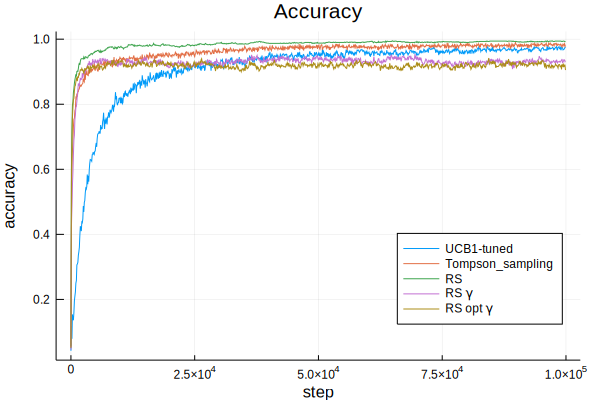

In [49]:
step_axis = [i for i=1:100:size(g1)[1]]
graph = [g1[i, :] for i in step_axis]
graph = hcat(graph...)'
#plot(1:size(g1)[1], g1, label=["RS","RS_tuned"], title="Accuracy")
#plot(step_axis, graph, title="Accuracy", label=[key for key in keys(algo_dict)], legend=:bottomright)
labels = [key for key in keys(algo_dict)]
plot(step_axis, graph, title="Accuracy", label=labels, xlabel="step",ylabel="accuracy", legend=:bottomright)

In [10]:
# step_axis2 = [i for i=1:10:size(g2)[1]]
# graph2 = [g2[i, :] for i in step_axis2]
# graph2 = hcat(graph2...)'
# #plot(step_axis2, graph2)
# plot(step_axis2, graph2, title="Regret", label=[key for key in keys(algo_dict)], xlabel="step",ylabel="regret", legend=:bottomright)

In [50]:
using CSV
using DataFrames

In [51]:
include("data_save.jl")

save_csv (generic function with 1 method)

In [59]:
save_csv(data=g2, file_name="./exp_data/teijo_regret_1K_100K.csv", labels=labels)

"./exp_data/teijo_regret_1K_100K.csv"

In [56]:
dataframe = CSV.read("./exp_data/teijo_accuracy_1K_100K_for_graph.csv", delim=',')

,step,UCB1-tuned,Tompson_sampling,RS,RS \gamma,RS opt \gamma
,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,1.0,0.042,0.053,0.057,0.046,0.051
2,101.0,0.118,0.434,0.6,0.423,0.555
3,201.0,0.079,0.594,0.72,0.485,0.68
4,301.0,0.154,0.656,0.796,0.549,0.758
5,401.0,0.141,0.686,0.807,0.59,0.789
6,501.0,0.136,0.73,0.836,0.645,0.814
7,601.0,0.16,0.754,0.848,0.69,0.818
8,701.0,0.196,0.757,0.865,0.705,0.841
9,801.0,0.21,0.78,0.875,0.753,0.855


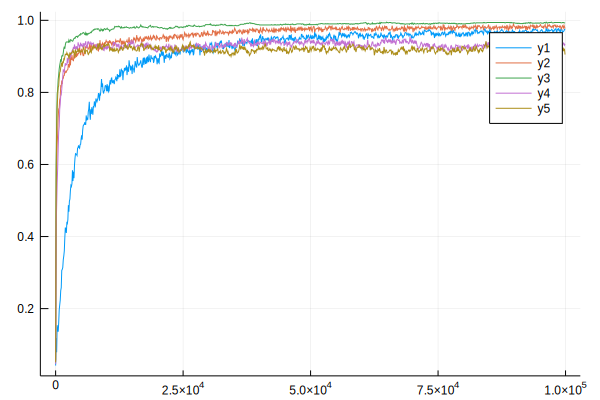

In [57]:
plot(dataframe[1], convert(Array, dataframe[[Symbol(str) for str in labels]]))